#**Assignment 2: Outlier diagnostics**

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [86]:
Group = "G4"
NAME = "Mr. Thananop Kullapan 6530182121"
COLLABORATORS = """
        Mr. Kanawut Suwandee    6870026821,
        Mrs. Yuwadee Tongkong  6872073621
        """

---

## Outlier diagnostics

This notebook provides:

- [Tools and packages](#tools-and-packages)
    - [Data processing](#data-loading-preprocessing-and-visualization)
- [Outlier analysis](#outlier-analysis)
    - [H-matrix](#h-matrix)   
    - [Cook's distance](#cooks-distance)
- Your tasks are to compair and discuss the difference between these methods
    - [Performance compairison](#performance-compairison)
    - [Are the outliers of the two methods intersect](#are-the-outliers-of-the-two-methods-intersect)
    - [How is the performance improved by the two outlier removals](#how-is-the-performance-improvement-by-the-two-outlier-removals)

You can run this notebook on collab:  <a target="_blank" href="https://colab.research.google.com/github/GenAI-CUEE/Statistical-Learning-EE575-Y2024/blob/master/Lab2/outlier_diagnostics.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Tools and Packages

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import seaborn as sns

def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm         = np.random.permutation(df.index)
    m            = len(df.index)
    train_end    = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end

    train        = df.iloc[perm[:train_end]]
    validate     = df.iloc[perm[train_end:validate_end]]
    test         = df.iloc[perm[validate_end:]]

    train       = train.drop(columns=["index"])
    validate    = validate.drop(columns=["index"])
    test        = test.drop(columns=["index"])

    train       = train.reset_index(drop=True)
    validate    = validate.reset_index(drop=True)
    test        = test.reset_index(drop=True)

    return train, validate, test

In [88]:
train_data = "https://raw.githubusercontent.com/GenAI-CUEE/Statistical-Learning-EE575/refs/heads/master/Lab2/house-prices-advanced-regression-techniques/train.csv"
df = pd.read_csv(train_data)
df.keys()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [89]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data loading, preprocessing, and visualization

In [90]:
target_column = ["SalePrice"]
feat_column   = [  "MoSold",        "YrSold",        "MSZoning",     "LandSlope",   "2ndFlrSF",  "CentralAir",    "TotRmsAbvGrd",  "TotalBsmtSF",  "GrLivArea",   "BldgType",    "OverallCond",   "BsmtHalfBath",  "ScreenPorch" ]

all_column = target_column + feat_column

In [91]:
df = df[all_column]
df = df.apply(LabelEncoder().fit_transform)

df = df.dropna()
df = df.reset_index()

In [92]:
df.head()

,index,SalePrice,MoSold,YrSold,MSZoning,LandSlope,2ndFlrSF,CentralAir,TotRmsAbvGrd,TotalBsmtSF,GrLivArea,BldgType,OverallCond,BsmtHalfBath,ScreenPorch
0,0,412,1,2,3,0,232,1,6,179,531,0,4,0,0
1,1,339,4,1,3,0,0,1,4,441,259,0,7,1,0
2,2,442,8,2,3,0,239,1,4,214,570,0,4,0,0
3,3,194,1,0,3,0,180,1,5,117,536,0,4,0,0
4,4,494,11,2,3,0,320,1,7,370,734,0,4,0,0


In [93]:
train, valid, test = train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None)

In [94]:
X_scaler = StandardScaler()
train[feat_column].values[:]        = X_scaler.fit_transform(train[feat_column].values[:] )
test[feat_column].values[:]         = X_scaler.transform(test[feat_column].values[:] )
valid[feat_column].values[:]        = X_scaler.transform(valid[feat_column].values[:] )

In [95]:
data_column =  target_column + feat_column
train_enc    = train.loc[:,data_column]

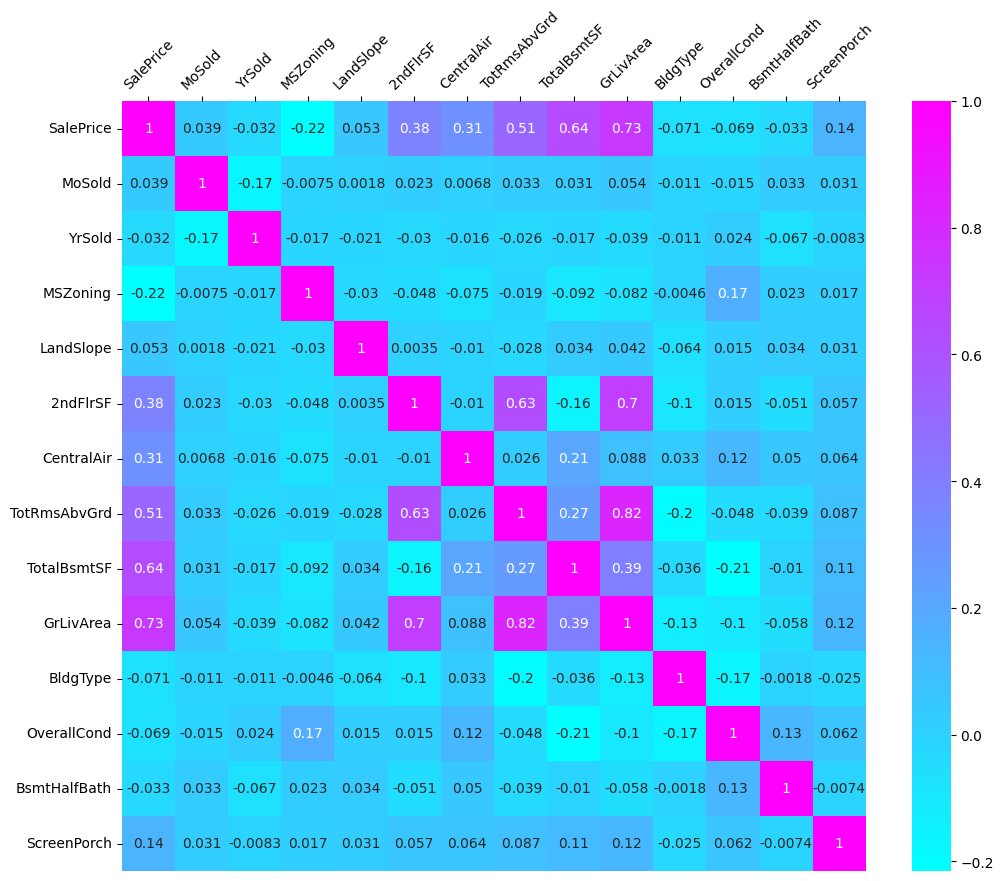

In [96]:
plt.figure(figsize=(12,10))
cor = train_enc.corr()
g = sns.heatmap(cor, annot=True, cmap=plt.cm.cool)
g.axes.xaxis.set_ticks_position("top")
plt.setp(g.axes.get_xticklabels(), rotation=45)
plt.show()

## Outlier analysis

### Settings

In [97]:
target_column = ["SalePrice"]
feat_column   = ["GrLivArea"]
outliers_percentile = 5

### H-matrix

Let $X$ be an array of training data. Then, H-matrix is defined by
$$ H = X (X^T X)^{-1} X^T $$

Write the function `H_matrix_leverage() ` using `X_train` to compute the diagonal entries of the H matrix.  

In [98]:
def H_matrix_leverage(X_train):
    # YOUR CODE HERE
    H = X_train @ np.linalg.inv(X_train.T @ X_train) @ X_train.T
    H_diag = np.diag(H)
    return H_diag

In [99]:
X_train   = train.loc[:,feat_column].values
[num_samples, num_feats]     = X_train.shape

H_diag = H_matrix_leverage(X_train)

In [100]:
# shape of matrix
print("Shape of X_train: ", X_train.shape)
print("Shape of H_diag: ", H_diag.shape)

Shape of X_train:  (1168, 1)
Shape of H_diag:  (1168,)


In [101]:
H_diag

array([6.55211693e-05, 2.59723399e-03, 8.30389092e-04, ...,
       1.95042998e-03, 2.20413214e-03, 2.98707761e-03])

Plot diagonal entries of hat matrix

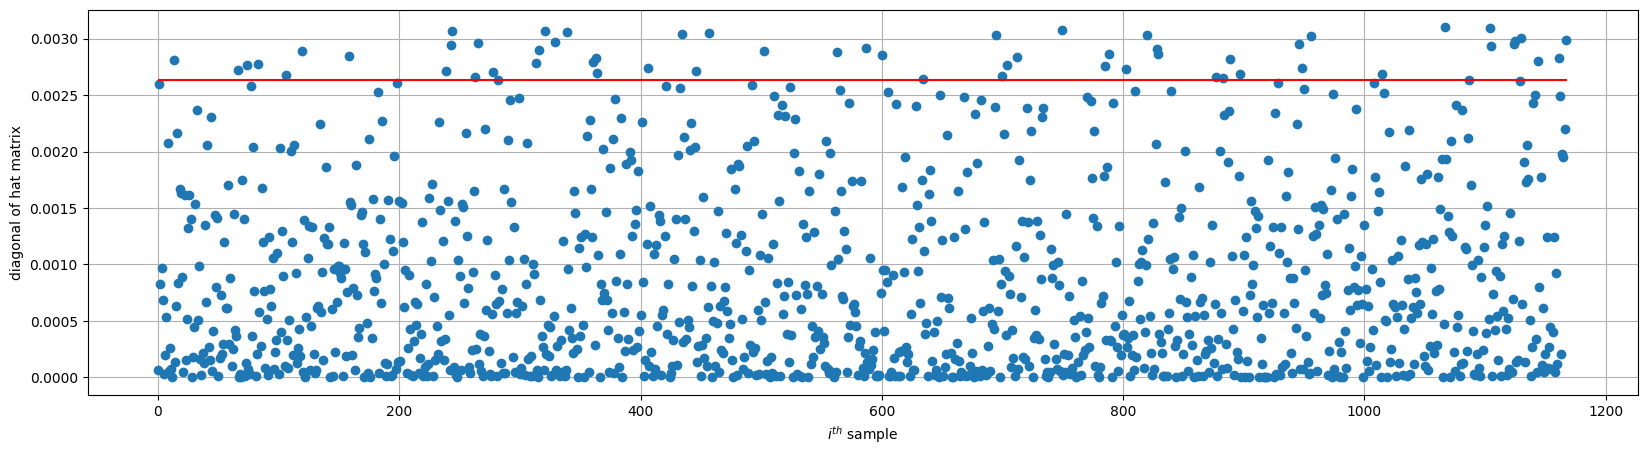

In [102]:
p_H = np.percentile(H_diag, 100-outliers_percentile)

plt.figure(figsize=(20,5))
plt.plot(H_diag, marker="o", ls='none')
plt.hlines(p_H, xmin=0, xmax=len(H_diag), colors="red")
plt.xlabel("$i^{th}$ sample")
plt.ylabel("diagonal of hat matrix")
plt.grid()

### Cook's distance

Each entry in the Cook's distance vector is defined by
$$ D_j = \frac{e^2_j \cdot h_{j,j}}{m \cdot \text{MSE}_{y}(\hat{y}) \cdot (1-h_{j,j})^2} $$

where each components are calculated using the following variables:

$[h_{j,j}]_{j = 1:m}$ := `H_diag`

$[e^2_j]_{j = 1:m}$ := `e_train`

$\text{MSE}_{y}(\hat{y})$ := `mse_train`

Here we will provide `e_train` and `mse_train` for you.

In [103]:
from sklearn.linear_model import LinearRegression

X_train = train[feat_column].values
y_train = train[target_column].values

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_train_predict = model_lr.predict(X_train)

e_train = (y_train - y_train_predict).reshape(-1)
mse_train = np.mean((y_train - y_train_predict)**2)

In [104]:
# Shape of e_train and mse_train
print("Shape of e_train: ", e_train.shape)          # (1168, )
print("Shape of mse_train: ", mse_train.shape, "and MSE =",mse_train)

Shape of e_train:  (1168,)
Shape of mse_train:  () and MSE = 13543.950080964456


Write the function `CookDistance()` using `e_train, mse_train, H_diag, num_feats` to compute Cook's distance vector.

In [105]:
def CookDistance(e_train, mse_train, H_diag, num_feats):
    # YOUR CODE HERE
    numerator = e_train**2 * H_diag
    denumerator = (len(e_train)) * (mse_train) * (1 - H_diag)**2
    Cook_D = numerator / denumerator
    return Cook_D

In [106]:
Cook_D = CookDistance(e_train, mse_train, H_diag, num_feats)

In [107]:
Cook_D

array([2.15720592e-10, 1.58133245e-06, 1.42917913e-06, ...,
       4.57467430e-08, 1.02598393e-08, 3.89286896e-06])

Plot Cook's distance entries

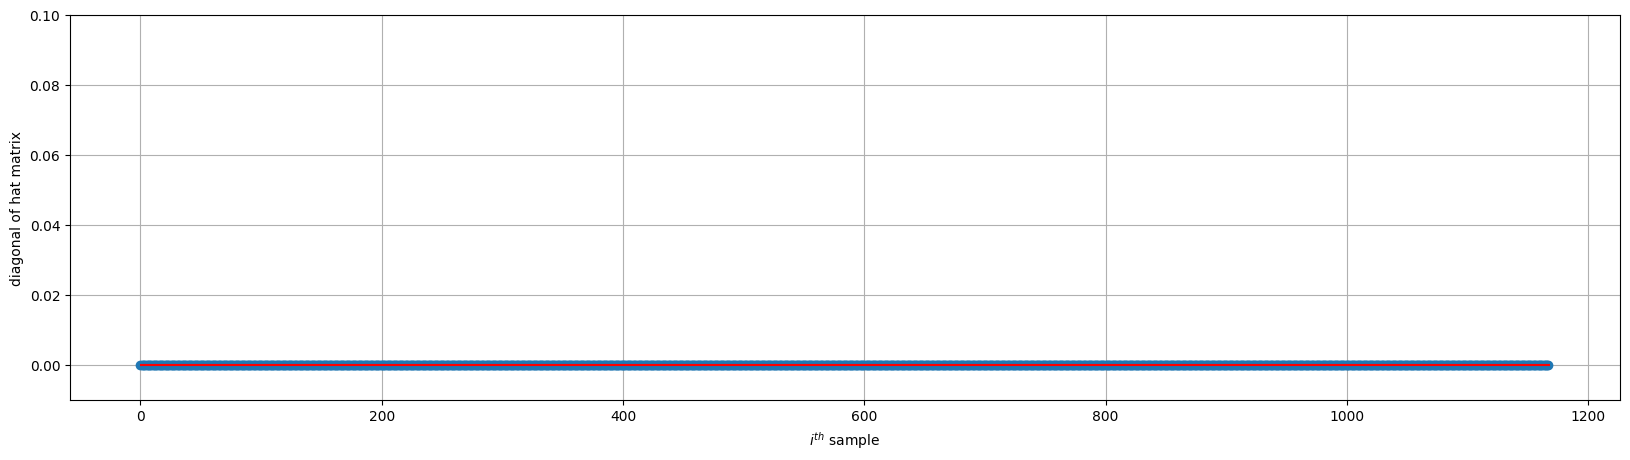

In [108]:
p_D = np.percentile(Cook_D, 100-outliers_percentile)

plt.figure(figsize=(20,5))
plt.plot(Cook_D, marker="o", ls='none')
plt.hlines(p_D, xmin=0, xmax=len(Cook_D), colors="red")
plt.xlabel("$i^{th}$ sample")
plt.ylabel("diagonal of hat matrix")
plt.ylim([-0.01,0.10])
plt.grid()

### Performance compairison

#### Are the outliers of the two methods intersect?

In [109]:
X_train_H  = X_train[H_diag <= p_H, :]
Y_train_H  = y_train[H_diag <= p_H]

X_train_H_outliers  = X_train[H_diag > p_H, :]
Y_train_H_outliers  = y_train[H_diag > p_H]


X_train_Cooks  = X_train[Cook_D <= p_D, :]
Y_train_Cooks  = y_train[Cook_D <= p_D]
X_train_Cooks_outliers  = X_train[Cook_D > p_D, :]
Y_train_Cooks_outliers  = y_train[Cook_D > p_D]

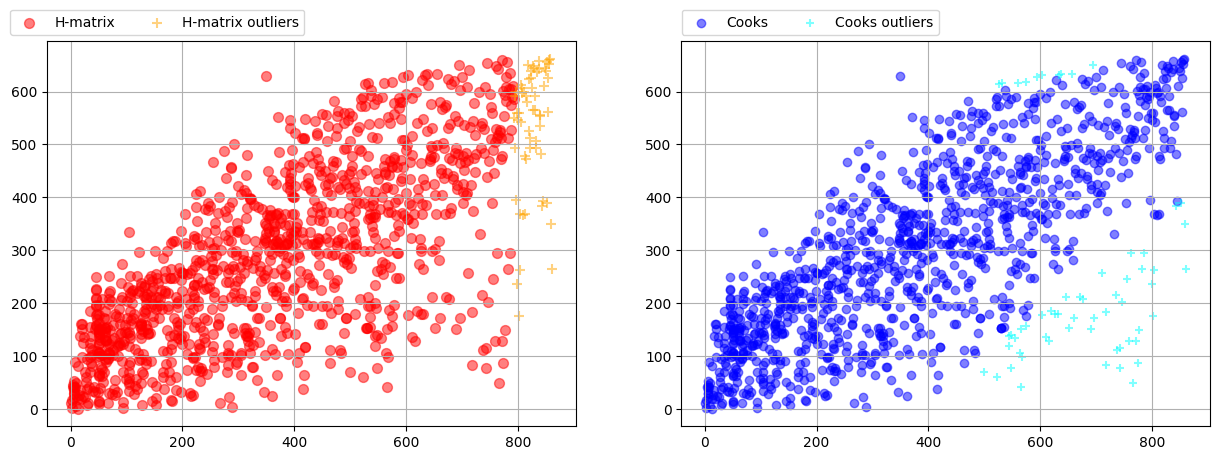

In [110]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(X_train_H, Y_train_H, color="red",  marker="o", label='H-matrix', s=50, alpha=0.5)
plt.scatter(X_train_H_outliers, Y_train_H_outliers, color="orange",  marker="+", label='H-matrix outliers', s=50, alpha=0.5)
plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=2)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X_train_Cooks, Y_train_Cooks, color="blue",  label='Cook''s', alpha=0.5)
plt.scatter(X_train_Cooks_outliers, Y_train_Cooks_outliers, color="cyan",  marker="+", label='Cook''s outliers',   alpha=0.5)
plt.xlabel("")
plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=2)
plt.grid()

#### How is the performance improvement by the two outlier removals?

Get the testing set

In [111]:
X_test = test[feat_column].values
y_test = test[target_column].values

Before outlier removal

In [112]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

Test on testing set

In [113]:
y_predict_test = model_lr.predict(X_test)

After outlier removal by H-matrix

In [114]:
model_lr_H = LinearRegression()
model_lr_H.fit(X_train_H, Y_train_H)

LinearRegression()

In [115]:
y_predict_H_test = model_lr_H.predict(X_test)

After outlier removal by Cook's distance

In [116]:
model_lr_D = LinearRegression()
model_lr_D.fit(X_train_Cooks, Y_train_Cooks)

LinearRegression()

In [117]:
y_predict_D_test = model_lr_D.predict(X_test)

Evaluations:

In [118]:
MSE_before = np.sqrt(np.mean((y_predict_test - y_test)**2))
MSE_after_H = np.sqrt(np.mean((y_predict_H_test - y_test)**2))
MSE_after_D = np.sqrt(np.mean((y_predict_D_test - y_test)**2))

In [119]:
print("MSE [before] = %.2f" % MSE_before)
print("MSE [after using H-matrix]     = %.2f" % MSE_after_H)
print("MSE [after using Cook's Dist.] = %.2f" % MSE_after_D)

MSE [before] = 115.85
MSE [after using H-matrix]     = 115.85
MSE [after using Cook's Dist.] = 117.59


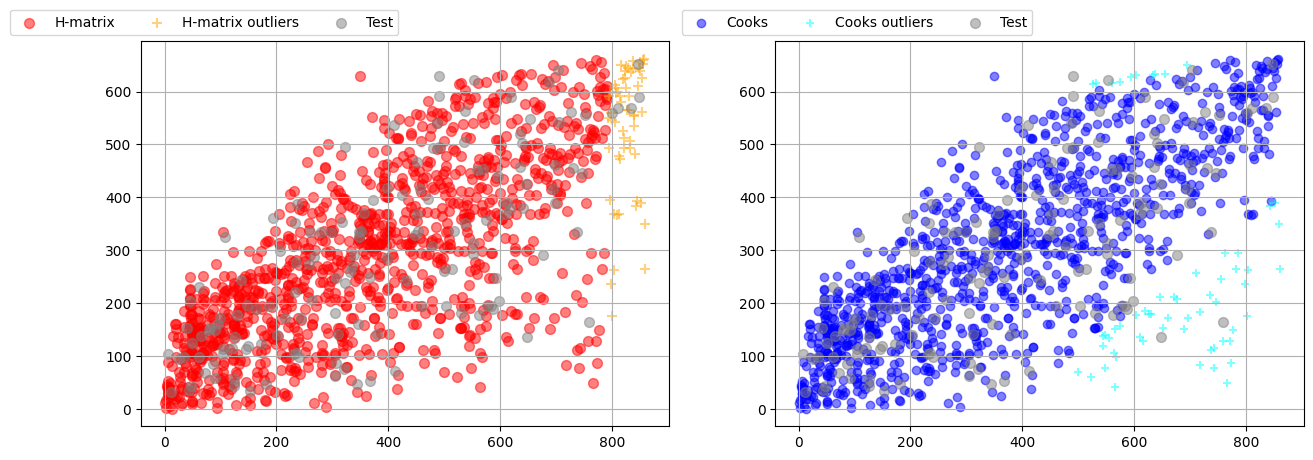

In [120]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(X_train_H, Y_train_H, color="red",  marker="o", label='H-matrix', s=50, alpha=0.5)
plt.scatter(X_train_H_outliers, Y_train_H_outliers, color="orange",  marker="+", label='H-matrix outliers', s=50, alpha=0.5)
plt.scatter(X_test, y_test, color="grey",  marker="o", label='Test', s=50, alpha=0.5)

plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=3)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X_train_Cooks, Y_train_Cooks, color="blue",  label='Cook''s', alpha=0.5)
plt.scatter(X_train_Cooks_outliers, Y_train_Cooks_outliers, color="cyan",  marker="+", label='Cook''s outliers',   alpha=0.5)
plt.scatter(X_test, y_test, color="grey",  marker="o", label='Test', s=50, alpha=0.5)

plt.xlabel("")
plt.legend(bbox_to_anchor=(0.50, 1.1), ncol=3)
plt.grid()